### Imports

In [206]:
from scipy.spatial.distance import minkowski, cosine
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

#### Distance metrices

In [207]:
def distance_metric(metric, x, y, p):
    if metric == 'minkowski':
        return minkowski(x, y, p)
    elif metric == 'cosine':
        return cosine(x, y)
    elif metric == 'chebyshev':
        return np.max(np.abs(x - y))
    else:
        raise ValueError(f"Unknown metric: {metric}")

#### Kernel functions

In [208]:
def kernel_fun(kernel, distances, a=2, b=2, fixed_window=True, h=1):
    normalized_distances = distances / h if fixed_window else distances / np.sort(distances)[-1]
    if kernel == 'uniform':
        return np.ones_like(distances)
    elif kernel == 'triangular':
        return np.maximum(0, 1 - normalized_distances)
    elif kernel == 'parabolic':
        return np.where(np.abs(normalized_distances) <= 1, 0.75 * (1 - normalized_distances ** 2), 0)
    elif kernel == 'general_view':
        return np.where(np.abs(normalized_distances) <= 1, (1 - np.abs(normalized_distances) ** a) ** b, 0)
    elif kernel == 'gaussian':
        return np.exp(-0.5 * normalized_distances ** 2) / np.sqrt(2 * np.pi)
    else:
        raise ValueError(f"Unknown kernel function: {kernel}")

#### KNN algorithm imlementation

In [209]:
class CustomKNN(BaseEstimator, ClassifierMixin):
    def __init__(self, *, k=5, a=2, b=2, kernel='triangular', p=2, metric='minkowski', fixed_window=True, h=1):
        self.nn = None
        self.y_train = None
        self.X_train = None
        self.X_weights = None
        self.k = k
        self.a = a
        self.b = b
        self.kernel = kernel
        self.p = p
        self.metric = lambda arr_1, arr_2: distance_metric(metric, arr_1, arr_2, p)
        self.fixed_window = fixed_window
        self.h = h
        self.weights = lambda distances: kernel_fun(kernel, distances, a, b, fixed_window, h)

    def fit(self, X_train, y_train, X_weights=None):
        self.X_train = X_train
        self.y_train = np.array(y_train)
        self.X_weights = np.ones(len(y_train)) if X_weights is None else np.array(X_weights)
        self.nn = NearestNeighbors(n_neighbors=self.k, metric=self.metric)
        self.nn.fit(X_train)

    def __nearest_neighbor_label(self, x):
        nearest_neighbor = self.nn.kneighbors(X=np.array([x]), n_neighbors=1)
        nearest_distance, nearest_indic = nearest_neighbor
        return self.y_train[nearest_indic][0][0]

    def predict(self, X_test):
        X_test = np.array(X_test)

        if self.fixed_window:
            neighbors = self.nn.radius_neighbors(X=X_test, radius=self.h)
        else:
            neighbors = self.nn.kneighbors(X=X_test, n_neighbors=self.k + 1)
        predictions = []
        X_i = 0
        for distances, indices in zip(*neighbors):
            default_label = self.__nearest_neighbor_label(X_test[X_i])
            neighbor_labels = self.y_train[indices]

            if len(neighbor_labels) == 0:
                predictions.append(default_label)
                continue

            weights = self.weights(distances)
            weighted_votes = {}
            for i, (label, weight) in enumerate(zip(neighbor_labels, weights)):
                total_weight = weight * self.X_weights[indices[i]]
                if label in weighted_votes:
                    weighted_votes[label] += total_weight
                else:
                    weighted_votes[label] = total_weight
            predictions.append(max(weighted_votes, key=weighted_votes.get))
            X_i += 1

        return np.array(predictions)

### Best hyperparams

In [210]:
phones = pd.read_csv('dataset.csv')
phones.columns.tolist()
phones.drop(columns=['model', 'release_date', 'main_camera'], inplace=True)
X = phones.drop(columns='company')
y = phones['company']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [211]:
param_grid = {
    'k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 16, 18, 20, 25],
    'kernel': ['triangular', 'uniform', 'gaussian', 'general_view', 'parabolic'],
    'metric': ['cosine', 'chebyshev', 'minkowski'],
    'p': [1, 2, 3, 4, 5, 10],
    'a': [1, 2, 3],
    'b': [1, 2, 3],
    'fixed_window': [True, False],
    'h': [0.5, 1, 2, 5, 10, 15, 25]
}


def useless_run(params):
    if not params['fixed_window'] and params['h'] != 1:
        return True
    if params['fixed_window'] and params['k'] != 1:
        return True
    if params['kernel'] != 'general_view' and (params['a'] != 1 or params['b'] != 1):
        return True
    if params['metric'] != 'minkowski' and params['p'] != 1:
        return True
    return False


def search_best_params():
    best_score = 0
    best_params = None

    keys, values = zip(*param_grid.items())
    param_combinations = list(itertools.product(*values))

    for combination in tqdm(param_combinations, desc="Grid Search Progress"):
        params = dict(zip(keys, combination))

        if useless_run(params):
            continue

        knn = CustomKNN(**params)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)

        score = accuracy_score(y_test, y_pred)

        if score > best_score:
            best_score = score
            best_params = params
    return best_params, best_score


# best_params, best_score = search_best_params()
best_params = {'k': 1, 'kernel': 'triangular', 'metric': 'cosine', 'p': 1, 'a': 1, 'b': 1, 'fixed_window': False,
               'h': 1}
best_score = 0.7177

print(f"Лучшие параметры: {best_params}")
print(f"Лучшая точность: {best_score:.4f}")

Лучшие параметры: {'k': 1, 'kernel': 'triangular', 'metric': 'cosine', 'p': 1, 'a': 1, 'b': 1, 'fixed_window': False, 'h': 1}
Лучшая точность: 0.7177


### Graphics

In [212]:
def plot_accuracy_vs_k():
    k_values = range(1, 50, 2)
    train_scores = []
    test_scores = []
    for k in k_values:
        knn = CustomKNN(k=k, kernel='triangular', metric='cosine', fixed_window=False)
        knn.fit(X_train, y_train)
        y_train_pred = knn.predict(X_train)
        train_acc = accuracy_score(y_train, y_train_pred)
        train_scores.append(train_acc)

        y_test_pred = knn.predict(X_test)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_scores.append(test_acc)

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, train_scores, label="Training Accuracy", marker='o')
    plt.plot(k_values, test_scores, label="Testing Accuracy", marker='o')
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Number of Neighbors (k)")
    plt.legend()
    plt.grid(True)
    plt.show()

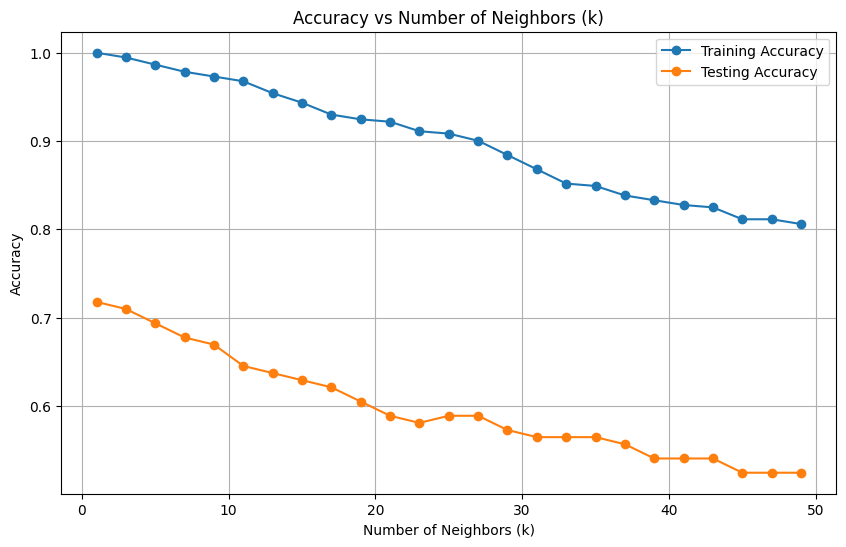

In [213]:
plot_accuracy_vs_k()

### Anomalies, Lowess algorithm

In [214]:
class LOWESSAnomalyDetector:
    def __init__(self, *, anomaly_weight=0.6, normal_weight=1, k=5, kernel='triangular', metric='cosine',
                 fixed_window=False):
        self.y_train = None
        self.X_train = None
        self.anomaly_weight = anomaly_weight
        self.normal_weight = normal_weight
        self.k = k
        self.kernel = kernel
        self.metric = metric
        self.fixed_window = fixed_window
        self.weights = None

    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)
        n_samples = X_train.shape[0]
        self.weights = np.ones(n_samples)

        for x in tqdm(range(n_samples), desc="Weighting train objects"):
            mask = np.ones(n_samples, dtype=bool)
            mask[x] = False
            X_train_subset = self.X_train[mask]
            y_train_subset = self.y_train[mask]

            knn = CustomKNN(k=self.k, kernel=self.kernel, metric=self.metric, fixed_window=self.fixed_window)
            knn.fit(X_train_subset, y_train_subset)
            y_pred = knn.predict([self.X_train[x]])[0]
            
            self.weights[x] = self.normal_weight if y_pred == self.y_train[x] else self.anomaly_weight

    def predict(self, X_test):
        knn = CustomKNN(k=self.k, kernel=self.kernel, metric=self.metric, fixed_window=self.fixed_window)
        knn.fit(self.X_train, self.y_train)
        
        return knn.predict(X_test)
    
    def predict_with_weights(self, X_test):
        knn = CustomKNN(k=self.k, kernel=self.kernel, metric=self.metric, fixed_window=self.fixed_window)
        knn.fit(self.X_train, self.y_train, self.weights)
        
        return knn.predict(X_test)

In [217]:
detector = LOWESSAnomalyDetector(k=10, anomaly_weight=0.9, normal_weight=1)
detector.fit(X_train, y_train)

y_pred_unweighted = detector.predict(X_test)
score_unweighted = accuracy_score(y_test, y_pred_unweighted)

y_pred_weighted = detector.predict_with_weights(X_test)
score_weighted = accuracy_score(y_test, y_pred_weighted)

print(f"Точность без взвешивания: {score_unweighted:.4f}")
print(f"Точность с учетом взвешивания: {score_weighted:.4f}")

Weighting train objects: 100%|██████████| 371/371 [00:10<00:00, 35.32it/s]


Точность без взвешивания: 0.6452
Точность с учетом взвешивания: 0.6532
